In [1]:
!pip install tensorflow

     |███████████████████████████▋    | 275.9 MB 110.9 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 320.4 MB 43 kB/s 
     |████████████████████████████████| 459 kB 116.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.0 MB/s s eta 0:00:01
     |████████████████████████████████| 127 kB 116.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 94.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 3.4 MB 64.5 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 91 kB 23.0 MB/s  eta 0:00:01
     |████████████████████████████████| 779 kB 110.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 18.2 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 117.3 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 124.8 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=561bb171f5f2024f96270c1ee70da9

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [2]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
def create_time_steps(length):
    return list(range(-length, 0))

In [6]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [7]:
tf.random.set_seed(13)

In [8]:
df = pd.read_csv('../../data/raw/parabola_100K.csv', index_col='x')
df.head()

,fx
x,
-50000,2500000000
-49999,2499900001
-49998,2499800004
-49997,2499700009
-49996,2499600016


In [10]:
int(df.shape[0] * 0.5)

50000

In [9]:
df.tail(5)

,fx
x,
49996,2499600016
49997,2499700009
49998,2499800004
49999,2499900001
50000,2500000000


## Training for 60% of the base

In [13]:
train = df.iloc[0:int(df.shape[0]*0.495)].values

In [18]:
test = df.iloc[int(df.shape[0]*0.495):].values

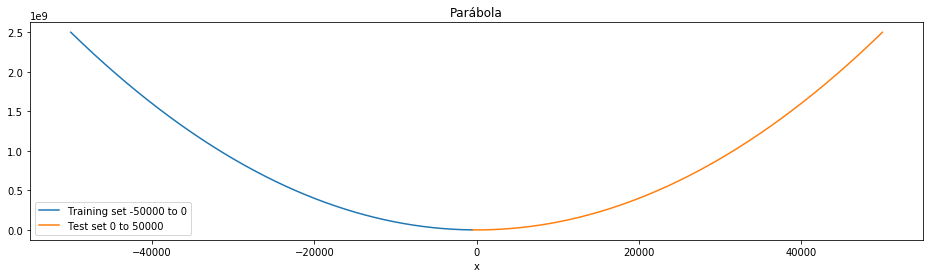

In [19]:
df["fx"].iloc[0:int(df.shape[0]*0.495)].plot(figsize=(16,4),legend=True)
df["fx"].iloc[int(df.shape[0]*0.495):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -50000 to 0',f'Test set 0 to 50000'])
plt.title('Parábola')
plt.show()

In [20]:
uni_data = df['fx']
uni_data.head()

x
-50000    2500000000
-49999    2499900001
-49998    2499800004
-49997    2499700009
-49996    2499600016
Name: fx, dtype: int64

In [21]:
uni_data = uni_data.values

In [25]:
uni_train_mean = uni_data[:int(df.shape[0]*0.495)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.495)].std()

In [26]:
uni_train_mean

841775250.1666666

In [27]:
uni_train_std

744381503.5726612

Let's standardize the data.

In [28]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [34]:
univariate_past_history = 900
univariate_future_target = 100

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.495),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.495), None,
                                       univariate_past_history,
                                       univariate_future_target)

# Model testing

In [35]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish',recurrent_activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(1))

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [36]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(300).batch(900).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(900).repeat()

Batch de 100 com shuffle de 50 não roda bem

In [37]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=5,
                                          steps_per_epoch=30,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
30/30 [==============================] - 89s 3s/step - loss: 0.5727 - val_loss: 0.5016
Epoch 2/5
30/30 [==============================] - 88s 3s/step - loss: 0.6516 - val_loss: 0.2204
Epoch 3/5
30/30 [==============================] - 88s 3s/step - loss: 0.1301 - val_loss: 0.2288
Epoch 4/5
30/30 [==============================] - 88s 3s/step - loss: 0.1523 - val_loss: 0.0983
Epoch 5/5
30/30 [==============================] - 88s 3s/step - loss: 0.0967 - val_loss: 0.0969


#### Swish - Sigmoid
- a função possui um loss bem proximo de seu validation durante todo o treinamento.
- elas começam a convergir mais para o final.
- na ultima época temos um loss e um validation loss bem próximos, na casa dos 10%
- Com Swish temos um ganho na distância das ondas, aqui a distância é de 2.

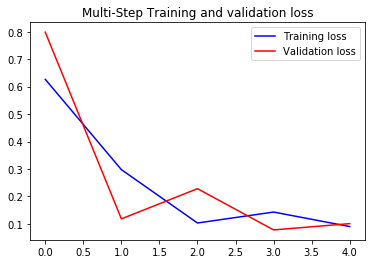

In [34]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.741462553344384, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


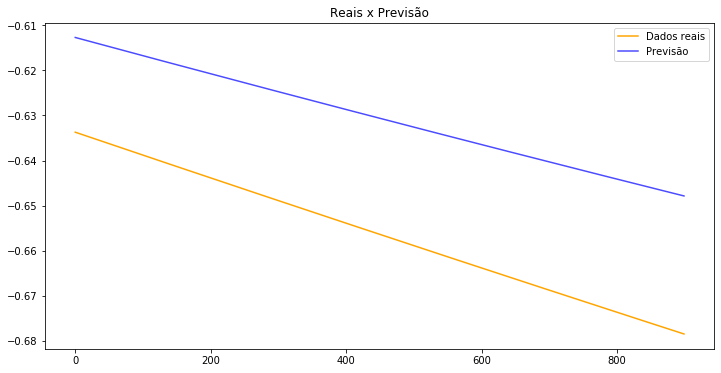

In [36]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

#### Swish - tanh

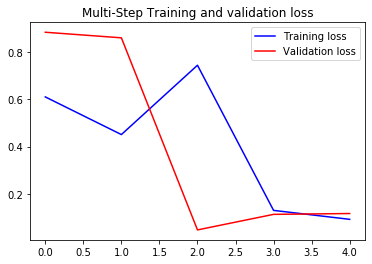

In [28]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7558181851012544, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


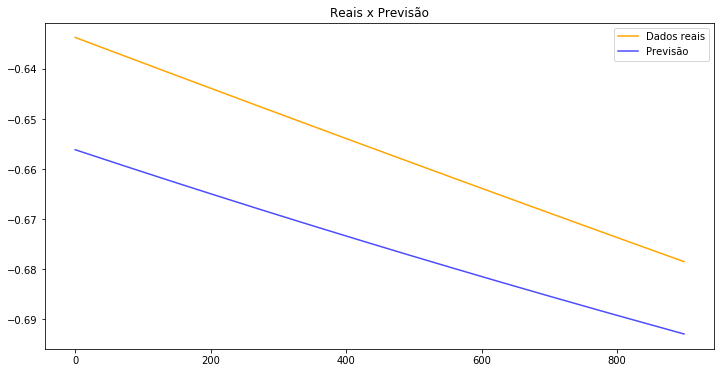

In [30]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

## Plottar O gráfico de -1000 a 1000
## Manter batchs maiores, próximos do nosso passado de treinamento

### Fazer um com tanh 
- testar com outros

#### Swish - TanH - 30 Steps
- Preciso diminuir o número de dados para enchergar melhor a curva do U

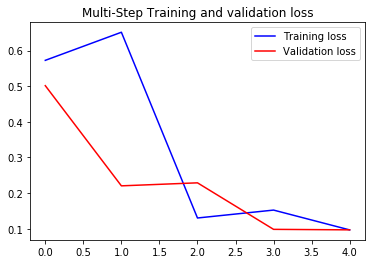

In [38]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.8703842070156742, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.8397672733757366, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9999987037017926, pvalue=0.0)


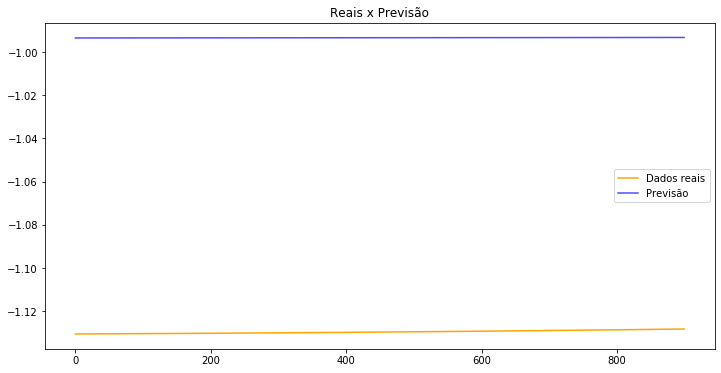

In [40]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()